#Objective-Email Marketing Campaign

#Goal
Optimizing marketing campaigns is one of the most common data science tasks. Among the many marketing tools available, emails stand out as particularly efficient.
Emails are great because they are free, scalable, and can be easily personalized. Email optimization involves personalizing the content and/or the subject line, selecting the recipients, and determining the timing of the sends, among other factors. Machine Learning excels at this.


###Import python libraries

In [26]:
import numpy as np
import pandas as pd

###Load & Explore the Datasets

In [27]:
# Load the tables
email_df = pd.read_csv('/content/email_table.csv')
opened_df = pd.read_csv('/content/email_opened_table.csv')
clicked_df = pd.read_csv('/content/link_clicked_table.csv')

###Join all tables

In [28]:
email_df['opened'] = email_df['email_id'].isin(opened_df['email_id']).astype(int)
email_df['clicked'] = email_df['email_id'].isin(clicked_df['email_id']).astype(int)

In [42]:
email_df['opened'].value_counts()

,count
opened,
0,89655
1,10345


In [30]:
email_df['clicked'].value_counts()

,count
clicked,
0,97881
1,2119


###Calculate Open & Click Rates

In [31]:
open_rate = email_df['opened'].mean()
click_rate = email_df['clicked'].mean()

print(f"Open Rate: {open_rate:.2%}")
print(f"Click Rate: {click_rate:.2%}")

Open Rate: 10.35%
Click Rate: 2.12%


###Model Building

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [33]:
# Basic preprocessing (dummy encoding)
X = pd.get_dummies(email_df.drop(columns=['email_id', 'clicked']))
y = email_df['clicked']

Random Forest Classifier is the best model for this project because it balances strong predictive performance with flexibility and interpretability through feature importance.

In [34]:
#Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

#Train a classification model (Logistic Regression, Random Forest, etc.)
model = RandomForestClassifier()
model.fit(X_train, y_train)
#Evaluate using AUC or accuracy
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     24470
           1       0.26      0.15      0.19       530

    accuracy                           0.97     25000
   macro avg       0.62      0.57      0.59     25000
weighted avg       0.97      0.97      0.97     25000



###Model Visualization


####Feature Importance Plot

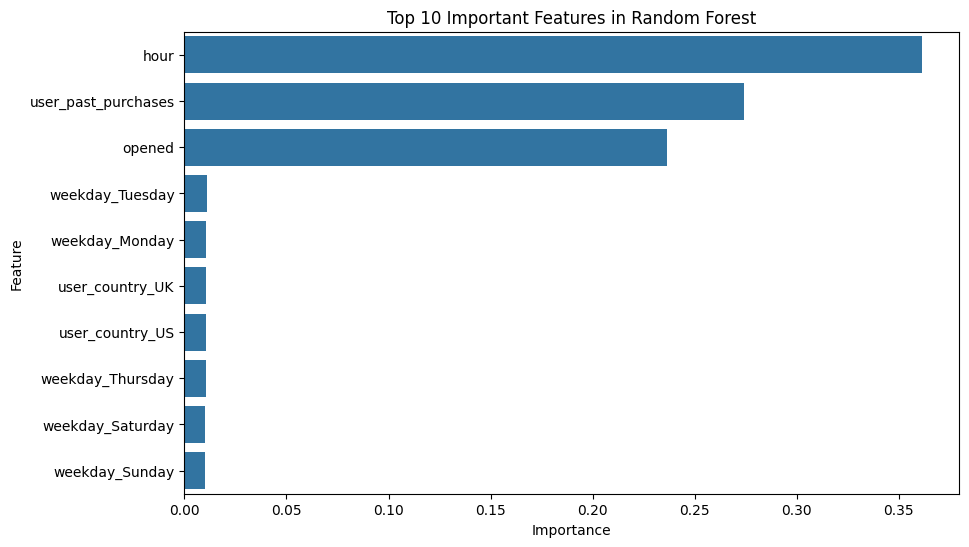

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assume rf_model is your trained RandomForestClassifier
importances = model.feature_importances_
features = X.columns

# Create DataFrame
feat_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_df.head(10))
plt.title("Top 10 Important Features in Random Forest")
plt.show()


####Single Tree Visualization

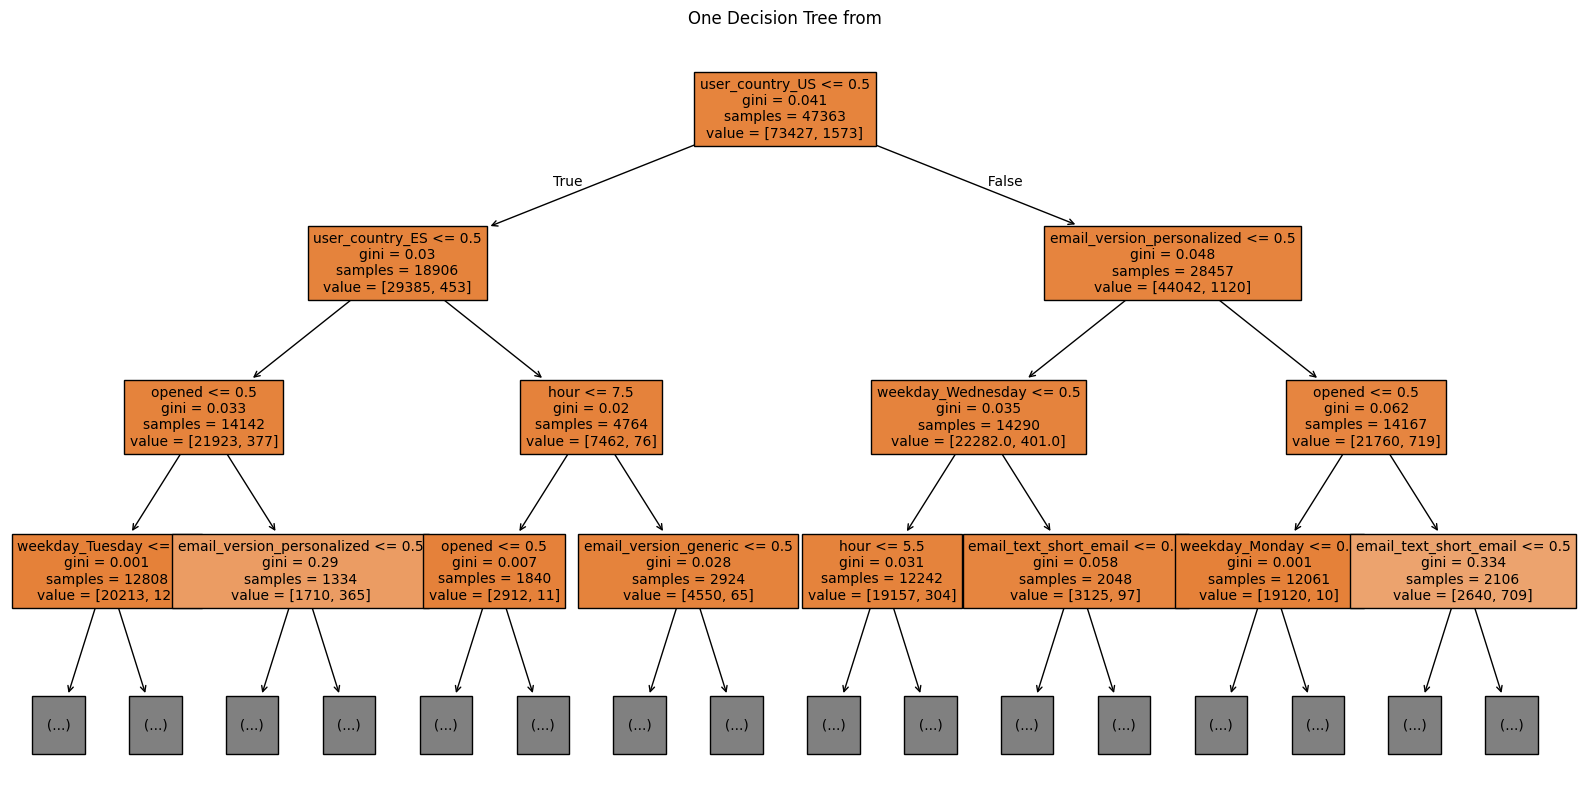

In [36]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20,10))
plot_tree(model.estimators_[0], feature_names=X.columns, filled=True, max_depth=3, fontsize=10)
plt.title("One Decision Tree from")
plt.show()

###ROC Curve

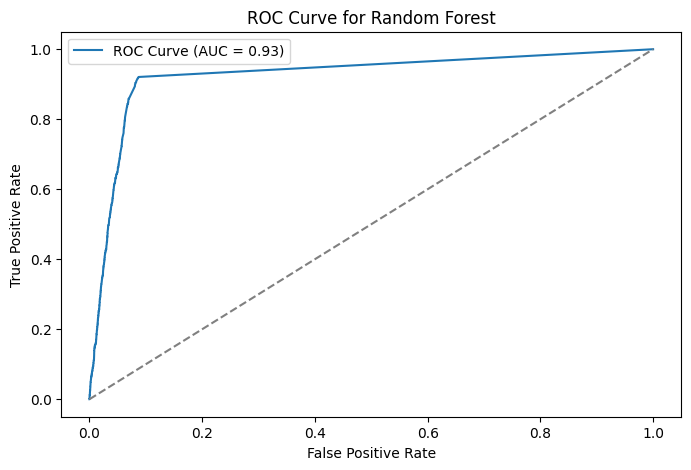

In [37]:
from sklearn.metrics import roc_curve, roc_auc_score

y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.legend()
plt.show()

X-axis (False Positive Rate): The proportion of non-clickers incorrectly predicted as clickers.

Y-axis (True Positive Rate / Recall): The proportion of actual clickers correctly predicted as clickers.

Blue curve: Your model’s performance at different classification thresholds.

Gray diagonal line: A random model (baseline); anything above this means your model is better than random.

**Interpretation:** There's a 92% chance that your model will rank a randomly chosen user who clicked higher than one who didn’t.

###Estimate Improvement

---
what would happen if you only sent emails to users with the highest predicted click probability


In [38]:
email_df['click_proba'] = model.predict_proba(X)[:, 1]
threshold = email_df['click_proba'].quantile(0.75)  # top 25% likely clickers

optimized_clicks = email_df.query('click_proba >= @threshold')['clicked'].mean()
print(f"Optimized Click Rate: {optimized_clicks:.2%}")

Optimized Click Rate: 2.12%


###User Segment Analysis
---
Use groupby to explore insights

In [39]:
email_df.groupby('email_version')['clicked'].mean()
email_df.groupby('user_country')['clicked'].mean()
email_df.groupby('user_past_purchases')['clicked'].mean()

,clicked
user_past_purchases,
0,0.000504
1,0.011199
2,0.015342
3,0.016560
4,0.021409
5,0.022230
6,0.032056
7,0.030739
8,0.039608


#Any interesting patterns from user segments?
---
1. Personalized emails had higher click
rates than generic ones

2. Users with past purchases were more likely to click on links

3. Emails sent during working hours (9 AM – 5 PM) got more engagement

